In [1]:
import requests as rq
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import os.path

In [45]:
filename = 'data.xlsx'

def normalize_2016(standings_df, stats_df):
    standings_df = standings_df[0]
    stats_df = stats_df[0]
    standings_df = standings_df.iloc[:, [0, 2]]
    standings_df = standings_df.rename(columns = {'PKT BEZ' : 'PKT'})
    stats_df = stats_df.rename(columns = {'Drużyna' : 'KLUB'})
    return standings_df.merge(stats_df)

def normalize_201718(standings_df, stats_df):
    standings_df = standings_df[0].iloc[:, [0, 2]]
    labels = ['PL', 'WIEK', 'WZROST']
    for index, label in enumerate(labels):
        curr_df = stats_df[index].iloc[:, -2:]
        curr_df = curr_df.replace({ "DR" : team_names_dict })
        curr_df = curr_df.rename(columns = {'DR' : 'KLUB', 'Średnia' : label})
        standings_df = standings_df.merge(curr_df)
    return standings_df

scraping_options = [
    {
        'url' : 'http://ekstrastats.pl/sezon-201617/',
        'standings' : 'tablepress-249',
        'stats' : ['tablepress-299'],
        'normalize' : normalize_2016
    },
    {
        'url' : 'http://ekstrastats.pl/sezon-2017-18/',
        'standings' : 'tablepress-348',
        'stats' : ['tablepress-359', 'tablepress-360', 'tablepress-361'],
        'normalize' : normalize_201718
    },
    {
        'url' : 'http://ekstrastats.pl/sezon-2018-19/',
        'standings' : 'tablepress-441',
        'stats' : ['tablepress-473', 'tablepress-474', 'tablepress-475'],
        'normalize' : normalize_201718
    }
]

team_names_dict = {
    'ARK' : 'Arka Gdynia',
    'BBT' : 'Bruk-Bet',
    'CRA' : 'Cracovia',
    'GÓR' : 'Górnik Zabrze',
    'JAG' : 'Jagiellonia',
    'KOR' : 'Korona Kielce',
    'LPO' : 'Lech Poznań',
    'LGD' : 'Lechia Gdańsk',
    'LEG' : 'Legia Warszawa',
    'PIA' : 'Piast Gliwice',
    'POG' : 'Pogoń Szczecin',
    'SAN' : 'Sandecja',
    'ŚLĄ' : 'Śląsk Wrocław',
    'WIS' : 'Wisła Kraków',
    'WPŁ' : 'Wisła Płock',
    'ZAG' : 'Zagłębie Lubin',
    'MIE' : 'Miedź Legnica',
    'ZSO' : 'Zagłębie Sosnowiec	'
}

def extract_dataframes(soup, standings_selector, stats_selectors):
    standings = soup.find(id = standings_selector)
    standings_df = pd.read_html(str(standings))
    stats = ''
    for stat in stats_selectors:
        st = soup.find(id = stat)
        stats += str(st)
    stats_df = pd.read_html(stats)
    return (standings_df, stats_df)

def scrape_data(scriping_options):
    df_list = []
    for scrape in scriping_options:
        response = rq.get(scrape['url'])
        soup = BeautifulSoup(response.text, 'html.parser')
        standings_df, stats_df = extract_dataframes(soup, standings_selector = scrape['standings'], stats_selectors = scrape['stats'])
        normalized_df = scrape['normalize'](standings_df, stats_df)
        normalized_df['GRUPA'] = pd.Series(['Mistrzowska' if i < 8 else 'Spadkowa' for i in range(16)])
        df_list.append(normalized_df)
    return pd.concat(df_list, ignore_index = True, sort = True)

if os.path.isfile(filename):
    df = pd.read_excel(filename, index_col = 0)
else:
    df = scrape_data(scraping_options)
    df.to_excel(filename)

df

,GRUPA,KLUB,PKT,PL,WIEK,WZROST
0,Mistrzowska,Legia Warszawa,73,546.0,2885.0,18309.0
1,Mistrzowska,Jagiellonia,71,459.0,2760.0,18189.0
2,Mistrzowska,Lech Poznań,69,700.0,2713.0,18277.0
3,Mistrzowska,Lechia Gdańsk,68,530.0,2788.0,18461.0
4,Mistrzowska,Korona Kielce,47,519.0,2745.0,18323.0
5,Mistrzowska,Wisła Kraków,48,770.0,2897.0,18088.0
6,Mistrzowska,Pogoń Szczecin,46,732.0,2629.0,18152.0
7,Mistrzowska,Bruk-Bet,46,522.0,2727.0,18241.0
8,Spadkowa,Zagłębie Lubin,53,727.0,2766.0,18354.0
9,Spadkowa,Piast Gliwice,46,541.0,2707.0,18167.0


In [46]:
POINTS = df['PKT']
AVG_AGE = df['WIEK']
AVG_HEIGHT = df['WZROST']
AVG_NUMBER_OF_POLES_IN_FIRST_ELEVEN = df['PL']
COLORS = ['green' if gr == 'Mistrzowska' else 'red' for gr in df['GRUPA'].to_list()]

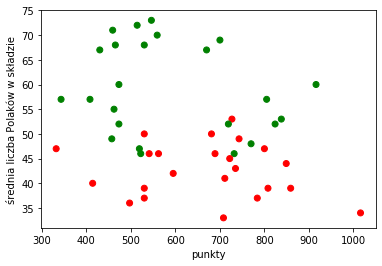

In [58]:
plt.scatter(AVG_NUMBER_OF_POLES_IN_FIRST_ELEVEN, POINTS, marker = 'o', facecolor = COLORS)
plt.xlabel('punkty')
plt.ylabel('średnia liczba Polaków w składzie')

plt.show()

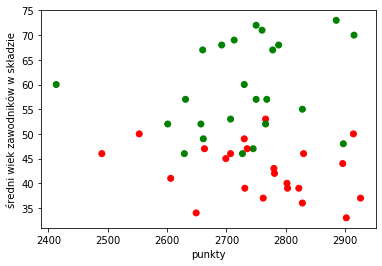

In [59]:
plt.scatter(AVG_AGE, POINTS, marker = 'o', facecolor = COLORS)
plt.xlabel('punkty')
plt.ylabel('średni wiek zawodników w składzie')

plt.show()

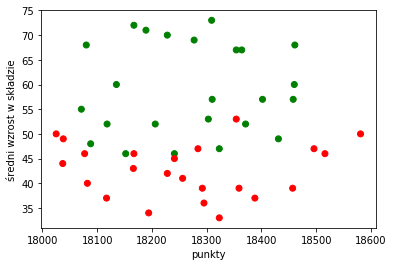

In [60]:
plt.scatter(AVG_HEIGHT, POINTS,  marker = 'o', facecolor = COLORS)
plt.xlabel('punkty')
plt.ylabel('średni wzrost w składzie')

plt.show()

Zbiór treningowy:  0.08956126675265819
Zbiór testujący:  0.013524774973854512


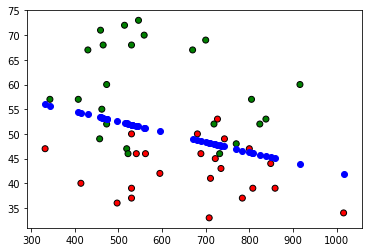

In [82]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = np.array(AVG_NUMBER_OF_POLES_IN_FIRST_ELEVEN)
Y = np.array(POINTS)

X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

plt.scatter(X, Y, marker = 'o', facecolor = COLORS, edgecolor = 'black')

x_tr, x_ts, y_tr, y_ts = train_test_split(X, Y)

linreg = LinearRegression().fit(x_tr, y_tr)
plt.scatter(X, linreg.predict(X), color='blue')

print("Zbiór treningowy: ", linreg.score(x_tr, y_tr))
print("Zbiór testujący: ", linreg.score(x_ts, y_ts))

plt.show()

In [102]:
X = np.array(AVG_NUMBER_OF_POLES_IN_FIRST_ELEVEN)
Y = df['GRUPA'].to_list()

X = X.reshape(-1, 1)

x_tr, x_ts, y_tr, y_ts = train_test_split(X, Y)

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(x_tr, y_tr)

x_nowy = np.array([[600]])
pred = knn.predict(x_nowy)
print(pred)

print(knn.predict(x_ts))

['Spadkowa']
['Mistrzowska' 'Spadkowa' 'Mistrzowska' 'Spadkowa' 'Mistrzowska'
 'Mistrzowska' 'Mistrzowska' 'Mistrzowska' 'Spadkowa' 'Mistrzowska'
 'Spadkowa' 'Mistrzowska']


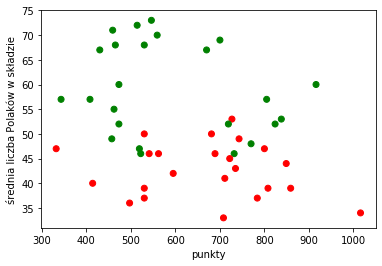

In [99]:
plt.scatter(AVG_NUMBER_OF_POLES_IN_FIRST_ELEVEN, POINTS, marker = 'o', facecolor = COLORS)
plt.xlabel('punkty')
plt.ylabel('średnia liczba Polaków w składzie')
plt.show()

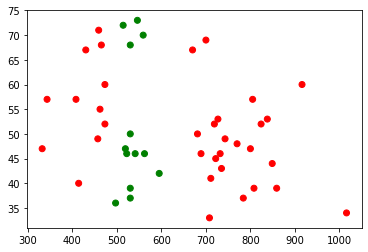

In [107]:
X = np.array(AVG_NUMBER_OF_POLES_IN_FIRST_ELEVEN)
Y = np.array(POINTS)

dane = np.array([X, Y]).T

import sklearn.cluster

km = sklearn.cluster.KMeans(n_clusters = 4)
km.fit(dane)

plec_pred = km.predict(dane)
plec_pred = ['green' if p == 0 else 'red' for p in plec_pred]
plt.scatter(X, Y, marker='o', facecolors=plec_pred)
plt.show()

plt.show()